## 1. Load the packages

In [1]:
# Data processing packages
import numpy as np
import pandas as pd
from collections import Counter

# Machine learning packages
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE, SelectPercentile, chi2, mutual_info_regression, SelectFromModel
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

import torch

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# Others
import time
from pathlib import Path

## 2. Read the data

In [2]:
X1 = pd.read_csv("X1.csv")
Y1 = pd.read_csv("Y1.csv", header=None, names=['revenue '])
X2 = pd.read_csv("X2.csv")

In [3]:
X1

,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,\N,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,2787,Stiff Upper Lips,https://m.media-amazon.com/images/M/MV5BNGRiMz...,Stiff Upper Lips: Directed by Gary Sinyor. Wit...,6.3,973.0,0,1997,94,Comedy,1999.0,Cow.,"[0.19991912, 1.3718543, 1.1531808, 0.052152418...","[-0.55224955, 0.26953417, 0.99950045, -0.98031..."
3536,2319,Twenty Two,https://m.media-amazon.com/images/M/MV5BMjMyMz...,Twenty Two: Directed by Jack Smight. With Barb...,8.0,2190.0,0,1961,25,"Drama,Fantasy,Horror",2017.0,CL,"[0.38660493, 0.81947947, 1.9521054, 0.23831718...","[-0.52293366, 0.35181606, 0.9992165, -0.974448..."
3537,1856,Girlfight,https://m.media-amazon.com/images/M/MV5BMTMzMz...,Girlfight: Directed by Lawrence Trilling. With...,7.6,34.0,0,2001,44,"Drama,Romance",2000.0,SGem,"[0.15014637, 2.0139444, 1.0844889, 0.17270318,...","[-0.61463475, 0.4013893, 0.99981415, -0.985390..."
3538,1531,This Film Is Not Yet Rated,https://m.media-amazon.com/images/M/MV5BMTk0ND...,This Film Is Not Yet Rated: Directed by Kirby ...,7.5,27379.0,0,2006,98,Documentary,2006.0,IFC,"[0.25391683, 3.8994913, 0.23327282, 0.17322594...","[-0.74685824, 0.43955636, 0.99979496, -0.98784..."


In [61]:
Path('../models/').mkdir(parents=True, exist_ok=True)
Path('../Fogures/').mkdir(parents=True, exist_ok=True)

## 3. Data Preprocessing

### STEP 1: Data Cleaning (columns drop off and missing value processing)

In [4]:
def data_cleaning_process(df):
    """
    This function will drop columns, like "Unnamed: 0", "title", "img_url", "description" from the dataset, and replace the missing value in `runtime` column with a median value, and replace the missing value in `genres` with "Others".
    :param df: A dataframe (X1 or X2)
    :return: A new cleaned dataframe
    """

    new_df = df.copy()
    # missing value for runtime: replace "\\N" with median value
    median_runtime = np.median(new_df.loc[new_df['runtime'] != '\\N', 'runtime'].astype(np.int64))
    new_df['runtime'] = np.where(new_df['runtime'] == '\\N', median_runtime, new_df['runtime']).astype(np.int64)

    # missing value for genres: replace "\\N" with "Others"
    new_df.loc[new_df['genres'] == "\\N", "genres"] = "Others"

    # drop "Unnamed: 0", "title", "img_url", "description"
    new_df = new_df.drop(["Unnamed: 0", "title", "img_url", "description"], axis=1)

    return new_df

In [5]:
X1_cleaned = data_cleaning_process(X1)

### STEP 2: Data Type Split (Numerical, Categorical, Embeddings)

In [6]:
def data_type_split(df):
    """
    This function will split the whole dataset into different sub dataset according to the data types of the columns
    :param df: A dataframe
    :return: three datadrames, which are numerical, categorical, embeddings
    """

    new_df = df.copy()
    numeric_features = new_df.select_dtypes(include="number").columns.tolist()
    non_numeric_features = new_df.select_dtypes(exclude="number").columns.tolist()
    embedding_features = ['img_embeddings', 'text_embeddings']
    numeric_features.remove('is_adult')
    categorical_features = non_numeric_features.copy()
    [categorical_features.remove(col) for col in embedding_features]
    categorical_features.append('is_adult')
    return new_df.loc[:, numeric_features], new_df.loc[:, categorical_features], new_df.loc[:, embedding_features]

In [7]:
df_num, df_cat, df_emb = data_type_split(X1_cleaned)

In [8]:
df_num.head()

,ratings,n_votes,production_year,runtime,release_year
0,6.5,92937.0,2010,105,2010.0
1,7.9,11.0,1996,95,2014.0
2,5.9,1345.0,1978,127,1978.0
3,6.6,4851.0,1994,105,1994.0
4,4.1,549.0,1982,108,1982.0


In [9]:
df_cat.head()

,genres,studio,is_adult
0,"Adventure,Comedy,Drama",Sum.,0
1,"Action,Crime,Drama",WF,0
2,"Drama,Family,Sport",MGM,0
3,"Biography,Drama,Sport",NL,0
4,"Crime,Drama,Sport",MGM,0


In [10]:
df_emb.head()

,img_embeddings,text_embeddings
0,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."


### STEP 3: Categorical Columns Processing (Genres --> multilable binary type, Studio --> studio_frequency)

In [11]:
dict_cat_freq = torch.load("studio_freq")

In [12]:
mlb = MultiLabelBinarizer()
df_cat['genres_split'] = df_cat['genres'].apply(lambda x: x.split(","))
mlb.fit(df_cat['genres_split'])

MultiLabelBinarizer()

In [13]:
def categorical_process(df):
    """
    This function will process on `genres` and `studio` columns.
    `genres` will be transformed to multilabel binary variables;
    `studio` will be transformed to a frequency type.
    :param df: A categorical datframe
    :return: A new dataframe
    """

    new_df = df.copy()

    # processing on `genres` column
    new_df['genres_split'] = new_df['genres'].apply(lambda x: x.split(","))
    # mlb = MultiLabelBinarizer()
    genere_encoder_df = pd.DataFrame(mlb.transform(new_df['genres_split']))
    genere_encoder_df.columns = mlb.classes_.tolist()

    # processing on `studio` column
    studio_freq_df = pd.DataFrame(new_df['studio'].apply(lambda x: dict_cat_freq[x] if x in dict_cat_freq.keys() else min(dict_cat_freq.values())))
    studio_freq_df.columns = ['studio_freq']


    processed_cat_df = pd.concat([genere_encoder_df, studio_freq_df, new_df['is_adult']], axis=1)

    return processed_cat_df

In [14]:
categorical_process(df_cat).columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Others',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western', 'studio_freq', 'is_adult'],
      dtype='object')

### STEP 4: Embedding Column Processing

In [15]:
def listToDF(df, column_name):

    new_df = []
    for row in df[column_name]:
        ls = []
        row = eval(row)
        for each in row:
            ls.append(each)
        new_df.append(ls)

    new_df = pd.DataFrame(new_df)

    return new_df

In [16]:
def embedding_process(df):
    new_df = df.copy()

    # image embeddings
    img_emb_df = listToDF(new_df, 'img_embeddings')
    text_emb_df = listToDF(new_df, 'text_embeddings')

    processed_emb_df = pd.concat([img_emb_df, text_emb_df], axis=1)
    return processed_emb_df

In [17]:
embedding_process(X1.loc[:, ['img_embeddings', 'text_embeddings']])

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.250308,2.405846,1.043157,0.030648,0.349497,0.320495,0.901077,0.674996,0.310549,0.533353,...,0.555539,-0.173167,0.399331,-0.378869,-0.409315,-0.344284,-0.073671,0.999885,-0.495468,0.959063
1,0.512502,2.815260,0.463082,0.290314,1.080451,0.333979,0.909705,0.817344,0.340002,0.507425,...,0.534597,-0.320714,0.385184,-0.552606,-0.399212,-0.445087,0.006780,0.999800,-0.508911,0.954674
2,0.180730,0.247355,0.636528,0.249652,0.100523,0.055299,0.850117,0.015236,0.232086,0.558831,...,0.697693,-0.035854,0.356325,-0.388621,-0.344016,-0.322001,-0.085762,0.999952,-0.458579,0.976136
3,0.025015,0.910534,0.387826,0.342125,0.449293,0.517494,0.213289,0.463569,0.863764,0.544507,...,0.692328,-0.009719,0.076474,-0.214084,-0.177248,0.025969,-0.112050,0.999954,-0.054416,0.977869
4,0.190797,1.906828,0.291144,0.195275,0.525999,0.502706,0.359901,0.074025,0.379786,0.182895,...,0.593455,-0.336046,0.406313,-0.384353,-0.334238,-0.377167,-0.131084,0.999879,-0.166202,0.951990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,0.199919,1.371854,1.153181,0.052152,0.536693,0.082999,0.327779,0.067693,0.368952,0.440536,...,0.618991,-0.185828,0.461786,-0.595909,-0.495862,-0.498804,0.012033,0.999901,-0.685967,0.966164
3536,0.386605,0.819479,1.952105,0.238317,0.502970,0.193758,1.336698,0.286949,0.489620,0.567320,...,0.372036,-0.195845,0.200071,-0.582929,-0.504679,-0.504943,-0.131687,0.999818,-0.662812,0.968601
3537,0.150146,2.013944,1.084489,0.172703,0.609013,0.387161,0.484712,0.408787,0.177421,0.471901,...,0.567243,-0.106148,0.392279,-0.381554,-0.285943,-0.322065,-0.178053,0.999946,-0.321442,0.979969
3538,0.253917,3.899491,0.233273,0.173226,1.474815,0.347801,0.720919,0.262827,0.411901,0.196077,...,0.739504,-0.176527,0.220067,-0.451745,-0.179833,-0.007636,-0.181650,0.999941,-0.309001,0.972790


### STEP 5: Combine Everything

In [18]:
def data_combine(df_num, df_cat, df_emb):
    new_df = pd.concat([df_num, df_cat, df_emb], axis=1)
    return new_df

In [19]:
df_processed = data_combine(df_num, categorical_process(df_cat), df_emb)

In [20]:
df_processed

,ratings,n_votes,production_year,runtime,release_year,Action,Adventure,Animation,Biography,Comedy,...,Sci-Fi,Short,Sport,Thriller,War,Western,studio_freq,is_adult,img_embeddings,text_embeddings
0,6.5,92937.0,2010,105,2010.0,0,1,0,0,1,...,0,0,0,0,0,0,0.001695,0,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,7.9,11.0,1996,95,2014.0,1,0,0,0,0,...,0,0,0,0,0,0,0.000565,0,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,5.9,1345.0,1978,127,1978.0,0,0,0,0,0,...,0,0,1,0,0,0,0.025141,0,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,6.6,4851.0,1994,105,1994.0,0,0,0,1,0,...,0,0,1,0,0,0,0.016949,0,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,4.1,549.0,1982,108,1982.0,0,0,0,0,0,...,0,0,1,0,0,0,0.025141,0,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,6.3,973.0,1997,94,1999.0,0,0,0,0,1,...,0,0,0,0,0,0,0.002825,0,"[0.19991912, 1.3718543, 1.1531808, 0.052152418...","[-0.55224955, 0.26953417, 0.99950045, -0.98031..."
3536,8.0,2190.0,1961,25,2017.0,0,0,0,0,0,...,0,0,0,0,0,0,0.001130,0,"[0.38660493, 0.81947947, 1.9521054, 0.23831718...","[-0.52293366, 0.35181606, 0.9992165, -0.974448..."
3537,7.6,34.0,2001,44,2000.0,0,0,0,0,0,...,0,0,0,0,0,0,0.005650,0,"[0.15014637, 2.0139444, 1.0844889, 0.17270318,...","[-0.61463475, 0.4013893, 0.99981415, -0.985390..."
3538,7.5,27379.0,2006,98,2006.0,0,0,0,0,0,...,0,0,0,0,0,0,0.026836,0,"[0.25391683, 3.8994913, 0.23327282, 0.17322594...","[-0.74685824, 0.43955636, 0.99979496, -0.98784..."


### STEP 6: Normalization and Standarization

In [21]:
def data_scaling(df):
    """
    This function will process on the numercial columns.
    For `ratings`, we will use normalization
    For the other columns, we will use standardization
    :param df:
    :return:
    """
    new_X = df.copy().to_numpy()
    # new_df = df.copy()

    # df_norm = new_df["ratings"]
    # df_stad = new_df.iloc[:, 1:]
    scaler_norm = MinMaxScaler().fit(new_X[:, 0].reshape([-1, 1]))
    scaler_stad = StandardScaler().fit(new_X[:, 1:5])
    new_X[:, 0] = scaler_norm.transform(new_X[:, 0].reshape([-1, 1])).ravel()
    new_X[:, 1:5] = scaler_stad.transform(new_X[:, 1:5])

    return new_X

In [22]:
data_scaling(df_processed)

array([[0.6067415730337079, 0.8091997164658064, 1.1113535552086757, ...,
        0,
        '[0.25030804, 2.4058464, 1.0431569, 0.030648155, 0.34949675, 0.32049546, 0.9010769, 0.67499596, 0.3105492, 0.53335327, 1.1203631, 1.1870352, 0.16469067, 0.08631029, 0.2536717, 0.8805131, 0.99093795, 0.5192096, 0.22073326, 1.1222858, 0.16405053, 0.43223396, 0.13318907, 0.15435342, 0.6851507, 0.29961434, 0.1571368, 0.36041096, 0.35249132, 0.41207317, 0.10110004, 0.8365802, 0.5149405, 0.956604, 0.9495678, 2.4414942, 0.3832077, 1.360116, 0.5607003, 0.21099378, 0.3635454, 0.9016296, 0.21133274, 0.80351084, 0.07196415, 0.7504479, 0.7727491, 0.6297995, 0.29605088, 0.6241131, 0.31069583, 0.47231564, 0.16313902, 0.20088163, 0.5571188, 0.38998926, 0.6070499, 0.28628415, 0.2539219, 0.7498281, 0.43571132, 0.5879961, 0.8000516, 0.35587543, 0.09601559, 0.13888705, 0.5510557, 0.22644973, 0.43565476, 0.5604339, 1.297827, 1.6763825, 0.26593068, 0.94142264, 1.0117874, 1.1187711, 0.62566483, 0.2033474, 0.4790194, 

### Construct Data Engineering Pipeline

In [23]:
def DataEngineering(df):
    df_cleaned = data_cleaning_process(df)
    df_num, df_cat, df_emb = data_type_split(df_cleaned)
    df_cat_processed = categorical_process(df_cat)
    df_emb_processed = embedding_process(df_emb)
    df_processed = data_combine(df_num, df_cat_processed, df_emb_processed)
    X_ready = data_scaling(df_processed)

    return X_ready

In [54]:
preprocess_transformer = FunctionTransformer(DataEngineering)
torch.save(preprocess_transformer, '../models/preprocessor')

In [25]:
p1 = Pipeline([
    ('Preprocessor', preprocess_transformer)
])

In [26]:
X1_pre = p1.fit_transform(X1)
X1_pre[:5, :]

array([[ 0.60674157,  0.80919972,  1.11135356, ...,  0.99988544,
        -0.49546754,  0.95906293],
       [ 0.76404494, -0.27177631, -0.07338902, ...,  0.9998001 ,
        -0.5089115 ,  0.9546743 ],
       [ 0.53932584, -0.25625834, -1.59662947, ...,  0.9999524 ,
        -0.45857945,  0.9761356 ],
       [ 0.61797753, -0.21547426, -0.24263796, ...,  0.99995446,
        -0.05441597,  0.97786885],
       [ 0.33707865, -0.26551794, -1.25813159, ...,  0.99987864,
        -0.16620223,  0.95198965]])

## 4. Feature Selection

### 4.1 Give the column names to the dataset

In [27]:
def renamingDataset(X):
    new_X = X.copy()
    new_df = pd.DataFrame(new_X)
    num_col_names = ['ratings', 'n_votes', 'production_year', 'runtime', 'release_year']
    cat_col_names = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Others',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western', 'studio_freq', 'is_adult']
    img_emb_names = []
    for i in range(2048):
        img_emb_names.append("img_emb_" + str(i))

    text_emb_names = []
    for i in range(768):
        text_emb_names.append("text_emb_" + str(i))

    all_col_names = num_col_names + cat_col_names + img_emb_names + text_emb_names

    new_df.columns = all_col_names

    return new_df

In [28]:
renamed_df_ready = renamingDataset(X1_pre)
renamed_df_ready.head()

,ratings,n_votes,production_year,runtime,release_year,Action,Adventure,Animation,Biography,Comedy,...,text_emb_758,text_emb_759,text_emb_760,text_emb_761,text_emb_762,text_emb_763,text_emb_764,text_emb_765,text_emb_766,text_emb_767
0,0.606742,0.809200,1.111354,0.398460,0.933839,0.0,1.0,0.0,0.0,1.0,...,0.555539,-0.173167,0.399331,-0.378869,-0.409315,-0.344284,-0.073671,0.999885,-0.495468,0.959063
1,0.764045,-0.271776,-0.073389,0.079814,1.366959,1.0,0.0,0.0,0.0,0.0,...,0.534597,-0.320714,0.385184,-0.552606,-0.399212,-0.445087,0.006780,0.999800,-0.508911,0.954674
2,0.539326,-0.256258,-1.596629,1.099479,-2.531122,0.0,0.0,0.0,0.0,0.0,...,0.697693,-0.035854,0.356325,-0.388621,-0.344016,-0.322001,-0.085762,0.999952,-0.458579,0.976136
3,0.617978,-0.215474,-0.242638,0.398460,-0.798642,0.0,0.0,0.0,1.0,0.0,...,0.692328,-0.009719,0.076474,-0.214084,-0.177248,0.025969,-0.112050,0.999954,-0.054416,0.977869
4,0.337079,-0.265518,-1.258132,0.494053,-2.098002,0.0,0.0,0.0,0.0,0.0,...,0.593455,-0.336046,0.406313,-0.384353,-0.334238,-0.377167,-0.131084,0.999879,-0.166202,0.951990


In [29]:
def divideDataset(df):
    new_df = df.copy()

    non_emb_df = new_df.iloc[:, :34]
    img_emb_df = new_df.iloc[:, 34:2082]
    text_emb_df = new_df.iloc[:, 2082:]

    return non_emb_df, img_emb_df, text_emb_df # pd.dataframe type

In [30]:
non_emb_df, img_emb_df, text_emb_df = divideDataset(renamed_df_ready)

### 4.2 DR on Embeddings

#### 4.2.1 Implement PCA for reducing the embedding features

In [31]:
scaler_emb = MinMaxScaler()
emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))
pca_emb = PCA(n_components=0.9)
pca_emb.fit(emb_df_scaled)

def DRembeddings_pca(img_emb_df, text_emb_df):

    # scale the data to the range between 0 and 1 before using PCA
    # scaler_emb = MinMaxScaler()
    # img_emb_df_scaled = scaler_emb.fit_transform(img_emb_df)
    # text_emb_df_scaled = scaler_emb.fit_transform(text_emb_df)
    emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

    # pca_emb = PCA(n_components=n_components)
    # df_reduced_emb = pd.DataFrame(pca_emb.fit_transform(emb_df_scaled))
    df_reduced_emb = pd.DataFrame(pca_emb.transform(emb_df_scaled))

    emb_col_names = []
    for i in range(df_reduced_emb.shape[1]):
        emb_col_names.append("emb_" + str(i))

    df_reduced_emb.columns = emb_col_names

    return df_reduced_emb

In [32]:
df_reduced_emb_pca = DRembeddings_pca(img_emb_df, text_emb_df)
df_reduced_emb_pca.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198
0,1.054328,-2.153237,-0.802997,-0.248707,1.349493,-0.057840,1.314132,-0.675291,1.171299,0.436517,...,-0.020153,-0.015117,0.237029,-0.028050,-0.023873,0.079219,-0.031364,-0.071154,-0.091889,-0.235259
1,2.129040,-1.483597,0.043256,0.420362,0.764355,-0.197161,-2.482356,0.903683,-1.484753,-0.512926,...,-0.194736,0.081447,0.099483,-0.115929,0.107830,0.129517,-0.144803,-0.000834,-0.156755,0.159004
2,-0.875198,1.225310,-0.543729,-1.675668,-0.747023,-0.841552,0.549715,-1.524902,-0.489789,0.147765,...,0.092746,0.026760,0.241836,0.224205,0.007772,0.136998,0.067925,-0.050262,0.116298,0.057964
3,-2.737351,-0.962277,-0.147203,0.202019,0.383081,0.646871,1.802819,0.555741,1.016410,0.509889,...,0.222160,-0.061716,0.269019,-0.029332,0.159303,0.049171,0.240762,-0.297771,-0.147129,0.116596
4,-0.188856,-1.475641,1.705273,0.440138,0.412238,-1.173195,-0.601143,-0.155727,-0.484766,-0.416415,...,-0.053639,-0.288431,0.096173,-0.151598,0.179133,0.025855,0.221040,0.155626,-0.151701,-0.016146


#### 4.2.2 tSNE for reducing the embedding features

In [33]:
scaler_emb = MinMaxScaler()
emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

def DRembeddings_tsne(img_emb_df, text_emb_df, n_components=2, perplexity=50):

    # scale the data to the range between 0 and 1 before using PCA
    # scaler_emb = MinMaxScaler()
    # img_emb_df_scaled = scaler_emb.fit_transform(img_emb_df)
    # text_emb_df_scaled = scaler_emb.fit_transform(text_emb_df)
    emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

    # pca_emb = PCA(n_components=n_components)
    tsne_emb = TSNE(n_components=n_components, perplexity=perplexity, init='pca', learning_rate='auto', random_state=42)
    df_reduced_emb = pd.DataFrame(tsne_emb.fit_transform(emb_df_scaled))

    emb_col_names = []
    for i in range(df_reduced_emb.shape[1]):
        emb_col_names.append("emb_" + str(i))

    df_reduced_emb.columns = emb_col_names

    return df_reduced_emb

In [34]:
df_reduced_emb_tsne = DRembeddings_tsne(img_emb_df, text_emb_df)
df_reduced_emb_tsne.head()

/Users/maurice/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


,emb_0,emb_1
0,2.205505,-1.205730
1,28.729061,-26.367271
2,-7.849283,-14.730238
3,-29.360437,-4.802016
4,-5.778462,-20.003820


#### 4.2.3 ICA for reducing the embedding features

In [35]:
scaler_emb = MinMaxScaler()
emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

def DRembeddings_ica(img_emb_df, text_emb_df, n_components=2):

    # scale the data to the range between 0 and 1 before using PCA
    # scaler_emb = MinMaxScaler()
    # img_emb_df_scaled = scaler_emb.fit_transform(img_emb_df)
    # text_emb_df_scaled = scaler_emb.fit_transform(text_emb_df)
    emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

    # pca_emb = PCA(n_components=n_components)
    ica_emb = FastICA(n_components=n_components, random_state=42, whiten='unit-variance')
    df_reduced_emb = pd.DataFrame(ica_emb.fit_transform(emb_df_scaled))

    emb_col_names = []
    for i in range(df_reduced_emb.shape[1]):
        emb_col_names.append("emb_" + str(i))

    df_reduced_emb.columns = emb_col_names

    return df_reduced_emb

In [36]:
df_reduced_emb_ica = DRembeddings_ica(img_emb_df, text_emb_df, n_components=199)
df_reduced_emb_ica.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198
0,0.007300,0.022656,-0.008855,-0.014460,0.000776,0.001368,0.025268,-0.009183,-0.001393,-0.002024,...,0.021366,-0.009760,-0.007513,-0.034198,-0.015045,0.001355,0.000769,-0.015154,0.012817,0.028232
1,-0.001009,0.005313,-0.012610,0.002129,0.020815,-0.053469,0.002041,0.048456,0.006257,-0.003913,...,0.027880,-0.004506,0.056801,-0.008037,-0.000993,-0.001617,-0.019603,-0.004312,-0.002191,-0.010193
2,0.016946,0.007830,0.028360,0.007835,0.011015,-0.037035,0.011231,-0.023978,-0.009499,0.006701,...,-0.007837,0.007091,-0.006161,-0.008875,-0.009261,-0.000853,-0.008768,0.005669,0.003331,-0.006304
3,0.016220,0.035255,-0.006310,0.000554,0.006437,0.011144,-0.011704,-0.021770,0.014936,-0.017658,...,-0.011209,-0.070941,-0.028411,-0.001306,-0.007548,-0.017130,0.001905,-0.047526,0.006366,0.004610
4,0.018276,0.016502,0.005583,-0.005335,-0.006887,0.000816,-0.029552,0.023299,0.051184,-0.007259,...,-0.004511,-0.001022,-0.031027,-0.004482,0.012535,0.015088,0.029979,0.006775,-0.028128,-0.006645


### 4.3 Feature Selection

We will predict the log(1 + Y1)

In [37]:
"""
    The forward feature selection takes a bit time, so we saved the feature selection reulst into a file using torch
"""
# np.random.seed(42)
# rfr = RandomForestRegressor(n_jobs=-1)
# sfs_34features = SequentialFeatureSelector(
#     rfr,
#     k_features=34,
#     forward=True,
#     floating=False,
#     verbose=2,
#     scoring='neg_mean_squared_error',
#     cv=10,
# ).fit(non_emb_df, np.log(1 + Y1.to_numpy().ravel()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [38]:
# if Path('../models').exists():
#     torch.save(sfs_34features, "../models/foward_feature_selection_34features")
# else:
#     Path('../model').mkdir(parents=True, exist_ok=True)
#     torch.save(sfs_34features, "../models/foward_feature_selection_34features")

In [47]:
# Load the feature selection result
sfs_34 = torch.load("../models/foward_feature_selection_34features")

In [48]:
sfs_result = pd.DataFrame.from_dict(sfs_34.get_metric_dict()).T
sfs_result

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(32,)","[-6.1876420393139515, -5.5820492548812615, -5....",-5.889816,"(studio_freq,)",0.346289,0.466249,0.155416
2,"(1, 32)","[-4.502130280528037, -4.722763239969194, -4.30...",-4.774273,"(n_votes, studio_freq)",0.385982,0.519692,0.173231
3,"(1, 4, 32)","[-3.3866749693831286, -3.4550240283269322, -2....",-3.590916,"(n_votes, release_year, studio_freq)",0.457121,0.615474,0.205158
4,"(1, 3, 4, 32)","[-3.006532154642085, -3.193989128568828, -2.90...",-3.367027,"(n_votes, runtime, release_year, studio_freq)",0.405093,0.545424,0.181808
5,"(0, 1, 3, 4, 32)","[-2.9923133116776652, -3.259032453143216, -2.8...",-3.283855,"(ratings, n_votes, runtime, release_year, stud...",0.398525,0.53658,0.17886
6,"(0, 1, 3, 4, 5, 32)","[-2.8527386966970294, -3.223958295122265, -2.8...",-3.189384,"(ratings, n_votes, runtime, release_year, Acti...",0.361425,0.486628,0.162209
7,"(0, 1, 3, 4, 5, 29, 32)","[-2.898309890745733, -3.299416816014807, -2.76...",-3.195304,"(ratings, n_votes, runtime, release_year, Acti...",0.353366,0.475778,0.158593
8,"(0, 1, 3, 4, 5, 27, 29, 32)","[-2.9215963939086147, -3.250660216352439, -2.7...",-3.178278,"(ratings, n_votes, runtime, release_year, Acti...",0.363216,0.48904,0.163013
9,"(0, 1, 3, 4, 5, 12, 27, 29, 32)","[-2.793076427494489, -3.214359015905074, -2.71...",-3.157666,"(ratings, n_votes, runtime, release_year, Acti...",0.341343,0.459589,0.153196
10,"(0, 1, 3, 4, 5, 12, 27, 29, 31, 32)","[-2.872435756998218, -3.173264589561916, -2.75...",-3.148809,"(ratings, n_votes, runtime, release_year, Acti...",0.331633,0.446515,0.148838


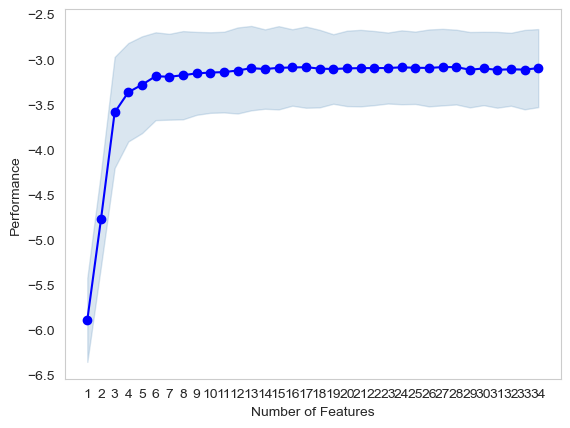

In [49]:
fig1 = plot_sfs(sfs_34.get_metric_dict(), kind='std_dev')
# plt.title('Forward Feature Selection (w. StdDev)')
plt.grid()
plt.savefig('../Figures/foward_selection.pdf')
plt.show()

In [50]:
sfs_34.k_score_

-3.0996136621777373

In [51]:
sfs_34.k_feature_idx_

(0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33)

In [52]:
np.argmax(sfs_result.loc[:, 'avg_score'])

27

In [53]:
features_selected = list(sfs_result.iloc[27, :]['feature_names'])
non_emb_df_selected = non_emb_df[features_selected]
non_emb_df_selected.head()

,ratings,n_votes,production_year,runtime,release_year,Action,Adventure,Biography,Comedy,Documentary,...,Others,Reality-TV,Romance,Short,Sport,Thriller,War,Western,studio_freq,is_adult
0,0.606742,0.809200,1.111354,0.398460,0.933839,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001695,0.0
1,0.764045,-0.271776,-0.073389,0.079814,1.366959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000565,0.0
2,0.539326,-0.256258,-1.596629,1.099479,-2.531122,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.025141,0.0
3,0.617978,-0.215474,-0.242638,0.398460,-0.798642,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.016949,0.0
4,0.337079,-0.265518,-1.258132,0.494053,-2.098002,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.025141,0.0


### 4.4 Combine selected non_emb with reduced emb

In [55]:
def combineNonReducedEmb(non_emb_df_selected, reduced_emb_df):
    DR_df = pd.concat([non_emb_df_selected, reduced_emb_df], axis=1)
    return DR_df

In [56]:
DR_df = combineNonReducedEmb(non_emb_df_selected, df_reduced_emb_pca)
DR_df.head()

,ratings,n_votes,production_year,runtime,release_year,Action,Adventure,Biography,Comedy,Documentary,...,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198
0,0.606742,0.809200,1.111354,0.398460,0.933839,0.0,1.0,0.0,1.0,0.0,...,-0.020153,-0.015117,0.237029,-0.028050,-0.023873,0.079219,-0.031364,-0.071154,-0.091889,-0.235259
1,0.764045,-0.271776,-0.073389,0.079814,1.366959,1.0,0.0,0.0,0.0,0.0,...,-0.194736,0.081447,0.099483,-0.115929,0.107830,0.129517,-0.144803,-0.000834,-0.156755,0.159004
2,0.539326,-0.256258,-1.596629,1.099479,-2.531122,0.0,0.0,0.0,0.0,0.0,...,0.092746,0.026760,0.241836,0.224205,0.007772,0.136998,0.067925,-0.050262,0.116298,0.057964
3,0.617978,-0.215474,-0.242638,0.398460,-0.798642,0.0,0.0,1.0,0.0,0.0,...,0.222160,-0.061716,0.269019,-0.029332,0.159303,0.049171,0.240762,-0.297771,-0.147129,0.116596
4,0.337079,-0.265518,-1.258132,0.494053,-2.098002,0.0,0.0,0.0,0.0,0.0,...,-0.053639,-0.288431,0.096173,-0.151598,0.179133,0.025855,0.221040,0.155626,-0.151701,-0.016146


### Construct Feature Selection Pipeline

In [58]:
def FeatureSelection(X, dr_method, n_components=2, perplexity=50):
    renamed_df_ready = renamingDataset(X)
    non_emb_df, img_emb_df, text_emb_df = divideDataset(renamed_df_ready)
    if dr_method == "pca":
        reduced_emb_df = DRembeddings_pca(img_emb_df, text_emb_df)
    elif dr_method == "tsne":
        reduced_emb_df = DRembeddings_tsne(img_emb_df, text_emb_df, n_components=n_components, perplexity=perplexity)
    elif dr_method == 'ica':
        reduced_emb_df = DRembeddings_ica(img_emb_df, text_emb_df, n_components=n_components)
    non_emb_df_selected = non_emb_df[features_selected]
    DR_df = combineNonReducedEmb(non_emb_df_selected, reduced_emb_df)

    return DR_df

In [59]:
feature_selection_transformer_pca = FunctionTransformer(FeatureSelection, kw_args={'dr_method':'pca'})
feature_selection_transformer_tsne = FunctionTransformer(FeatureSelection, kw_args={'dr_method':'tsne', 'n_components':3, 'perplexity':100})
feature_selection_transformer_ica = FunctionTransformer(FeatureSelection, kw_args={'dr_method':'ica', 'n_components':199})
torch.save(feature_selection_transformer_pca, '../models/FeatureSelectionPCA')
torch.save(feature_selection_transformer_tsne, '../models/FeatureSelectionTSNE')
torch.save(feature_selection_transformer_ica, '../models/FeatureSelectionICA')

In [ ]:
p2_pca = Pipeline([
    ('Preprocessor', preprocess_transformer),
    ('FeatureSelectionPCA', feature_selection_transformer_pca),
])

p2_tsne = Pipeline([
    ('Preprocessor', preprocess_transformer),
    ('FeatureSelectionTSNE', feature_selection_transformer_tsne),
])

p2_ica = Pipeline([
    ('Preprocessor', preprocess_transformer),
    ('FeatureSelectionICA', feature_selection_transformer_ica),
])

In [ ]:
X1_pca = p2_pca.fit_transform(X1)
torch.save(X1_pca, "X1_pca")
X1_pca.head()

In [ ]:
X1_tsne = p2_tsne.fit_transform(X1)
torch.save(X1_tsne, "X1_tsne")
X1_tsne.head()

In [ ]:
X1_ica = p2_ica.fit_transform(X1)
torch.save(X1_ica, "X1_ica")
X1_ica.head()

## 5. Models

In [2]:
X1_pca = torch.load('X1_pca').to_numpy()
X1_ica = torch.load('X1_ica').to_numpy()
X1_tsne = torch.load('X1_tsne').to_numpy()
Y1 = pd.read_csv("Y1.csv", header=None, names=['revenue ']).to_numpy().ravel()

In [3]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X1_pca, Y1, random_state=42, test_size=0.1)
X_train_ica, X_test_ica, _, _ = train_test_split(X1_ica, Y1, random_state=42, test_size=0.1)
X_train_tsne, X_test_tsne, _, _ = train_test_split(X1_tsne, Y1, random_state=42, test_size=0.1)

### 5.1 Linear regression

In [4]:
LR_pca = LinearRegression()
LR_ica = LinearRegression()
LR_tsne = LinearRegression()

In [5]:
# # np.random.seed(42)
# scores = cross_val_score(LR_model_pca, X_train_pca, np.log(1 + y_train), scoring='r2', cv=10)
# print("R^2 of the Linear Regression based on the PCA embeddings: {:.6} %".format(scores.mean()*100))
# scores = cross_val_score(LR_model_pca, X_train_pca, np.log(1 + y_train), scoring='neg_root_mean_squared_error', cv=10)
# print("RMSE of the Linear Regression based on the PCA embeddings: {:.4}".format(scores.mean()))

In [6]:
# scores = cross_val_score(LR_model_ica, X_train_ica, np.log(1 + y_train), scoring='r2', cv=10)
# print("R^2 of the Linear Regression based on the ICA embeddings: {:.6} %".format(scores.mean()*100))
# scores = cross_val_score(LR_model_ica, X_train_ica, np.log(1 + y_train), scoring='neg_root_mean_squared_error', cv=10)
# print("RMSE of the Linear Regression based on the ICA embeddings: {:.4} ".format(scores.mean()))

In [7]:
LR_pca.fit(X_train_pca, np.log(1 + y_train))
y_pred_LR_pca = np.exp(LR_pca.predict(X_test_pca)) - 1
print("Root mean squared error (PCA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_LR_pca))/1000000))
# r2_score(y_test, y_pred_LR_pca)

Root mean squared error (PCA Embeddings): 1478.50 Millions


In [8]:
LR_ica.fit(X_train_ica, np.log(1 + y_train))
y_pred_LR_ica = np.exp(LR_ica.predict(X_test_ica)) - 1
print("Root mean squared error (ICA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_LR_ica)) / 1000000))

Root mean squared error (ICA Embeddings): 1462.45 Millions


In [9]:
LR_tsne.fit(X_train_tsne, np.log(1 + y_train))
y_pred_LR_tsne = np.exp(LR_tsne.predict(X_test_tsne)) - 1
print("Root mean squared error (tSNE Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_LR_tsne))/1000000))

Root mean squared error (tSNE Embeddings): 1261.71 Millions


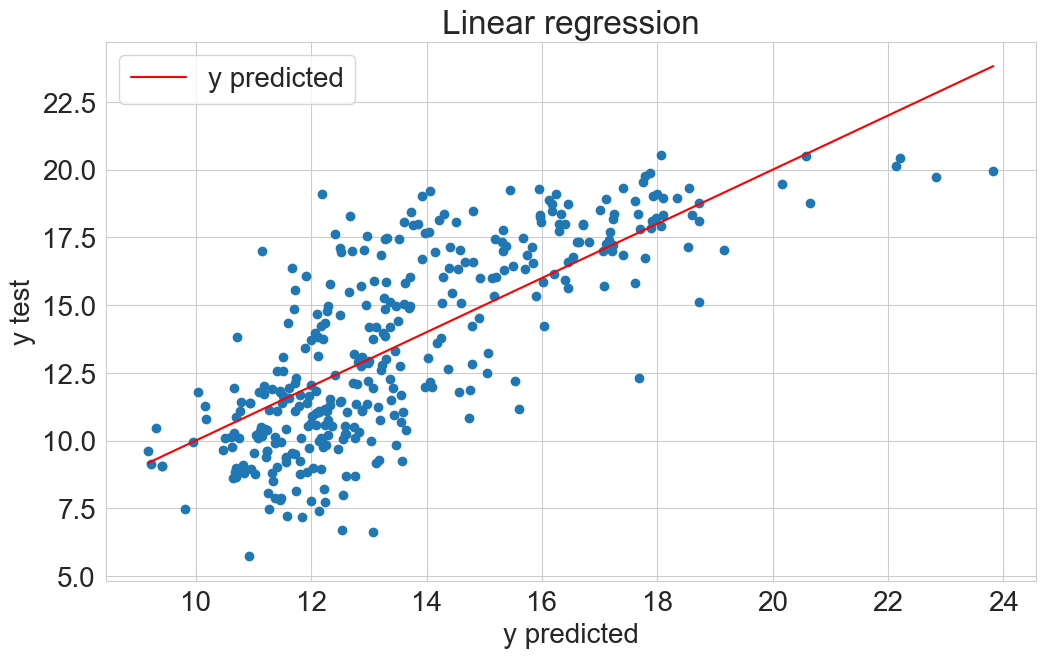

In [10]:
plt.rc("font", size=20)
plt.figure(figsize=(12,7))
plt.title('Linear regression')
plt.xlabel("y predicted")
plt.ylabel("y test")
plt.plot(np.log(y_pred_LR_tsne), np.log(y_test),'o')
plt.plot(np.linspace(np.min(np.log(y_pred_LR_tsne)),np.max(np.log(y_pred_LR_tsne)),2),np.linspace(np.min(np.log(y_pred_LR_tsne)),np.max(np.log(y_pred_LR_tsne)),2), label="y predicted",color="red")
plt.legend()

### 5.2 KNN

In [17]:
knn = KNeighborsRegressor()
knn_k_range = list(range(1, 41))
knn_param_grid = {
    'n_neighbors': knn_k_range
}

In [18]:
knn_grid_pca = GridSearchCV(knn, knn_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
knn_grid_ica = GridSearchCV(knn, knn_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
knn_grid_tsne = GridSearchCV(knn, knn_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)

In [19]:
## Model selection
# knn_grid_pca.fit(X_train_pca, np.log(1 + y_train))
# knn_grid_ica.fit(X_train_ica, np.log(1 + y_train))
# knn_grid_tsne.fit(X_train_tsne, np.log(1 + y_train))

## Save the model selection results
# torch.save(knn_grid_pca, '../models/knn_grid_pca')
# torch.save(knn_grid_ica, '../models/knn_grid_ica')
# torch.save(knn_grid_tsne, '../models/knn_grid_tsne')

## Load the results
knn_grid_pca = torch.load('../models/knn_grid_pca')
knn_grid_ica = torch.load('../models/knn_grid_ica')
knn_grid_tsne = torch.load('../models/knn_grid_tsne')

In [24]:
print("[knn_grid_pca] The best parameter K is:", knn_grid_pca.best_params_)
print("[knn_grid_pca] The best RMSE is:", knn_grid_pca.best_score_)
print()
print("[knn_grid_ica] The best parameter K is:", knn_grid_ica.best_params_)
print("[knn_grid_ica] The best RMSE is:", knn_grid_ica.best_score_)
print()
print("[knn_grid_tsne] The best parameter K is:", knn_grid_tsne.best_params_)
print("[knn_grid_tsne] The best RMSE is:", knn_grid_tsne.best_score_)

[knn_grid_pca] The best parameter K is: {'n_neighbors': 22}
[knn_grid_pca] The best RMSE is: -2.9175044373092835

[knn_grid_ica] The best parameter K is: {'n_neighbors': 13}
[knn_grid_ica] The best RMSE is: -2.5662457263191483

[knn_grid_tsne] The best parameter K is: {'n_neighbors': 12}
[knn_grid_tsne] The best RMSE is: -3.24501342188343


In [25]:
knn_grid_ica.cv_results_

{'mean_fit_time': array([0.00166638, 0.00181937, 0.00144291, 0.00183141, 0.00130978,
        0.00158269, 0.00156178, 0.00159557, 0.00137258, 0.00138652,
        0.00157666, 0.00232878, 0.00127811, 0.00140305, 0.00205228,
        0.00141797, 0.00133142, 0.00130665, 0.00157607, 0.00126796,
        0.00142775, 0.00134478, 0.00139878, 0.00137756, 0.00128474,
        0.00161676, 0.00144441, 0.00128818, 0.00145438, 0.0014478 ,
        0.00136271, 0.00139809, 0.00142486, 0.00131814, 0.00131304,
        0.00146976, 0.00146518, 0.00126913, 0.00123951, 0.0014806 ]),
 'std_fit_time': array([3.40235292e-04, 5.14408116e-04, 2.52818818e-04, 4.77451373e-04,
        1.59315077e-04, 4.69406852e-04, 3.80521433e-04, 5.25550136e-04,
        1.81547318e-04, 2.16160525e-04, 4.63528837e-04, 1.71800472e-03,
        1.56065305e-04, 3.26339924e-04, 6.87919728e-04, 2.82120780e-04,
        2.53279794e-04, 1.48772974e-04, 5.46477105e-04, 2.34310735e-04,
        2.60402977e-04, 2.53694200e-04, 2.45599131e-04, 1.489

In [31]:
def plot_rmse_line(grid_search_list, label_list, fig_name):

    plt.figure(figsize=(16, 8))

    for i in range(len(grid_search_list)):
        grid_search = grid_search_list[i]
        cv_result = grid_search.cv_results_
        mean_test_score = np.abs(cv_result['mean_test_score'])
        min_x = np.argmin(mean_test_score) + 1
        min_y = np.min(mean_test_score)

        plt.plot(mean_test_score, label=label_list[i])
        if i == len(grid_search_list) - 1:
            plt.scatter(min_x, min_y, c='r', marker='x', label='minimum')
        else:
            plt.scatter(min_x, min_y, c='r', marker='x')

    plt.legend()
    plt.xlabel('K neighbours')
    plt.ylabel('RMSE')
    plt.savefig('../Figures/' + fig_name)
    plt.show()

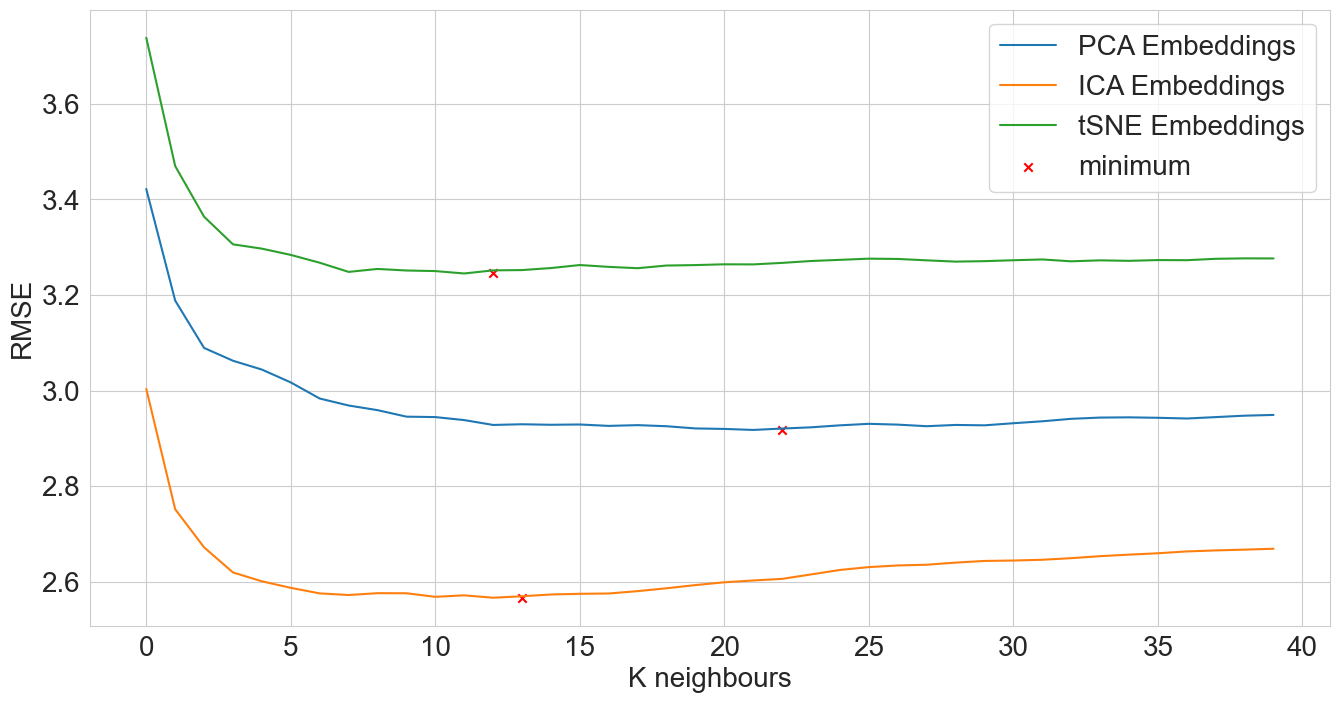

In [32]:
grid_search_list = [knn_grid_pca, knn_grid_ica, knn_grid_tsne]
label_list = ['PCA Embeddings', 'ICA Embeddings', 'tSNE Embeddings']
plot_rmse_line(grid_search_list, label_list, 'KNN_model_selection.pdf')

#### Use the best K parameters

In [33]:
knn_22 = KNeighborsRegressor(n_neighbors=22) # PCA
knn_13 = KNeighborsRegressor(n_neighbors=13) # ICA
knn_12 = KNeighborsRegressor(n_neighbors=12) # TSNE

In [39]:
knn_22.fit(X_train_pca, np.log(1 + y_train))
y_pred_knn_22_pca = np.exp(knn_22.predict(X_test_pca)) - 1
print("Root mean squared error (PCA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_knn_22_pca))/1000000))
print("R-square (PCA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_knn_22_pca)*100))

Root mean squared error (PCA Embeddings): 92.45 Millions
Root mean squared error (PCA Embeddings): 14.28 %


In [43]:
knn_13.fit(X_train_ica, np.log(1 + y_train))
y_pred_knn_13_ica = np.exp(knn_13.predict(X_test_ica)) - 1
print("Root mean squared error (ICA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_knn_13_ica))/1000000))
print("R-square (ICA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_knn_13_ica)*100))

Root mean squared error (ICA Embeddings): 82.24 Millions
Root mean squared error (ICA Embeddings): 32.18 %


In [44]:
knn_12.fit(X_train_tsne, np.log(1 + y_train))
y_pred_knn_12_ica = np.exp(knn_12.predict(X_test_tsne)) - 1
print("Root mean squared error (TSNE Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_knn_12_ica))/1000000))
print("R-square (TSNE Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_knn_12_ica)*100))

Root mean squared error (TSNE Embeddings): 104.16 Millions
Root mean squared error (TSNE Embeddings): -8.79 %


### 5.3 MLP

In [48]:
mlp = MLPRegressor(random_state=42, max_iter=1000, verbose=0)
hidden_layer_lists = [
    (200,),
    (200, 175,),
    (200, 175, 150,),
    (200, 175, 150, 125,),
    (200, 175, 150, 125, 100,),
    (200, 175, 150, 125, 100, 75,),
    (200, 175, 150, 125, 100, 75, 50,),
    (200, 175, 150, 125, 100, 75, 50, 25,),
    (200, 175, 150, 125, 100, 75, 50, 25, 10)
]
mlp_parameter_grid = {
    'hidden_layer_sizes': hidden_layer_lists,
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'batch_size': [177],
    'learning_rate': ['constant','adaptive'],
}

In [49]:
mlp_grid_pca = GridSearchCV(mlp, mlp_parameter_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
mlp_grid_ica = GridSearchCV(mlp, mlp_parameter_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
mlp_grid_tsne = GridSearchCV(mlp, mlp_parameter_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)

In [50]:
## Find the best parameters for mlp regressor using three different features
# mlp_grid_pca.fit(X_train_pca, np.log(1 + y_train))
# mlp_grid_ica.fit(X_train_ica, np.log(1 + y_train))
# mlp_grid_tsne.fit(X_train_tsne, np.log(1 + y_train))

## Save the grid search results
# torch.save(mlp_grid_pca, "../models/mlp_grid_pca")
# torch.save(mlp_grid_ica, "../models/mlp_grid_ica")
# torch.save(mlp_grid_tsne, "../models/mlp_grid_tsne")

In [22]:
## Load the model selection results
mlp_grid_pca = torch.load("../models/mlp_grid_pca")
mlp_grid_ica = torch.load("../models/mlp_grid_ica")
mlp_grid_tsne = torch.load("../models/mlp_grid_tsne")

In [53]:
print("[mlp_grid_pca] The best parameters are:", mlp_grid_pca.best_params_)
print("[mlp_grid_pca] The best RMSE is:", mlp_grid_pca.best_score_)
print()
print("[mlp_grid_ica] The best parameters are:", mlp_grid_ica.best_params_)
print("[mlp_grid_ica] The best RMSE is:", mlp_grid_ica.best_score_)
print()
print("[mlp_grid_tsne] The best parameters are:", mlp_grid_tsne.best_params_)
print("[mlp_grid_tsne] The best RMSE is:", mlp_grid_tsne.best_score_)

[mlp_grid_pca] The best parameters are: {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 177, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'solver': 'adam'}
[mlp_grid_pca] The best RMSE is: -2.366255956054574

[mlp_grid_ica] The best parameters are: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 177, 'hidden_layer_sizes': (200,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
[mlp_grid_ica] The best RMSE is: -2.189728879932728

[mlp_grid_tsne] The best parameters are: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 177, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'solver': 'adam'}
[mlp_grid_tsne] The best RMSE is: -2.2697205948344994


#### Use the best parameters for MLP regressor

In [24]:
mlp_pca = MLPRegressor(
    hidden_layer_sizes=(200,),
    learning_rate='constant',
    solver='adam',
    activation='tanh',
    alpha=0.0001,
    batch_size=177,
    random_state=42, max_iter=1000, verbose=0
)

mlp_ica = MLPRegressor(
    hidden_layer_sizes=(200,),
    learning_rate='adaptive',
    solver='sgd',
    activation='relu',
    alpha=0.0001,
    batch_size=177,
    random_state=42, max_iter=1000, verbose=0
)

mlp_tsne = MLPRegressor(
    hidden_layer_sizes=(200,),
    learning_rate='constant',
    solver='adam',
    activation='relu',
    alpha=0.0001,
    batch_size=177,
    random_state=42, max_iter=1000, verbose=0
)

In [27]:
mlp_pca.fit(X_train_pca, np.log(1 + y_train))
y_pred_mlp_pca = np.exp(mlp_pca.predict(X_test_pca)) - 1
print("Root mean squared error (PCA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_mlp_pca))/1000000))
print("R-square (PCA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_mlp_pca)*100))

Root mean squared error (PCA Embeddings): 179.91 Millions
R-square (PCA Embeddings): -224.61 %


In [57]:
mlp_ica.fit(X_train_ica, np.log(1 + y_train))
y_pred_mlp_ica = np.exp(mlp_ica.predict(X_test_ica)) - 1
print("Root mean squared error (ICA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_mlp_ica))/1000000))
print("R-square (ICA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_mlp_ica)*100))

Root mean squared error (PCA Embeddings): 174.54 Millions
R-square (PCA Embeddings): -205.51 %


/Users/maurice/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [58]:
mlp_tsne.fit(X_train_tsne, np.log(1 + y_train))
y_pred_mlp_tsne = np.exp(mlp_tsne.predict(X_test_tsne)) - 1
print("Root mean squared error (PCA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_mlp_tsne))/1000000))
print("R-square (PCA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_mlp_tsne)*100))

Root mean squared error (PCA Embeddings): 467.67 Millions
R-square (PCA Embeddings): -2093.34 %


### 5.4 Random Forest

In [8]:
rfr = RandomForestRegressor(random_state=42)
rfr_param_grid = {
    'n_estimators': [200, 400, 600],
    'bootstrap': [True, False],
     'max_depth': [10],
     'max_features': ['log2'],
     'min_samples_leaf': [2, 4],
     'min_samples_split': [2, 5],
}

In [9]:
rfr_grid_pca = GridSearchCV(rfr, rfr_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
rfr_grid_ica = GridSearchCV(rfr, rfr_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)
rfr_grid_tsne = GridSearchCV(rfr, rfr_param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True,verbose=2)

In [10]:
## Model Selection for Random Forest Regressor
# rfr_grid_pca.fit(X_train_pca, np.log(1 + y_train))
# rfr_grid_ica.fit(X_train_ica, np.log(1 + y_train))
# rfr_grid_tsne.fit(X_train_tsne, np.log(1 + y_train))

## Save the grid search results
# torch.save(rfr_grid_pca, "../models/rfr_grid_pca")
# torch.save(rfr_grid_ica, "../models/rfr_grid_ica")
# torch.save(rfr_grid_tsne, "../models/rfr_grid_tsne")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   5.2s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   5.1s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.7s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; tota

In [29]:
## Load the model selection results
rfr_grid_pca = torch.load("../models/rfr_grid_pca")
rfr_grid_ica = torch.load("../models/rfr_grid_ica")
rfr_grid_tsne = torch.load("../models/rfr_grid_tsne")

In [30]:
print("[rfr_grid_pca] The best parameters are:", rfr_grid_pca.best_params_)
print("[rfr_grid_pca] The best RMSE is:", rfr_grid_pca.best_score_)
print()
print("[rfr_grid_ica] The best parameters are:", rfr_grid_ica.best_params_)
print("[rfr_grid_ica] The best RMSE is:", rfr_grid_ica.best_score_)
print()
print("[rfr_grid_tsne] The best parameters are:", rfr_grid_tsne.best_params_)
print("[rfr_grid_tsne] The best RMSE is:", rfr_grid_tsne.best_score_)

[rfr_grid_pca] The best parameters are: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
[rfr_grid_pca] The best RMSE is: -2.547160281036047

[rfr_grid_ica] The best parameters are: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
[rfr_grid_ica] The best RMSE is: -2.5702710570313307

[rfr_grid_tsne] The best parameters are: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
[rfr_grid_tsne] The best RMSE is: -2.041374795876287


In [15]:
y_pred_rfr_pca = np.exp(rfr_grid_pca.predict(X_test_pca)) - 1
print("Root mean squared error (PCA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_rfr_pca))/1000000))
print("R-square (PCA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_rfr_pca)*100))

Root mean squared error (PCA Embeddings): 104.38 Millions
R-square (PCA Embeddings): -9.25 %


In [31]:
y_pred_rfr_ica = np.exp(rfr_grid_ica.predict(X_test_ica)) - 1
print("Root mean squared error (ICA Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_rfr_ica))/1000000))
print("R-square (ICA Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_rfr_ica)*100))

Root mean squared error (ICA Embeddings): 104.67 Millions
R-square (ICA Embeddings): -9.86 %


In [32]:
y_pred_rfr_tsne = np.exp(rfr_grid_tsne.predict(X_test_tsne)) - 1
print("Root mean squared error (TSNE Embeddings): {:.2f} Millions".format(np.sqrt(mean_squared_error(y_test, y_pred_rfr_tsne))/1000000))
print("R-square (TSNE Embeddings): {:.2f} %".format(r2_score(y_test, y_pred_rfr_tsne)*100))

Root mean squared error (ICA Embeddings): 94.97 Millions
R-square (ICA Embeddings): 9.56 %


## 6. Prediction

In [64]:
preprocess_transformer = torch.load('../models/preprocessor')
FeatureSelectionICA = torch.load('../models/processor')
knn_grid_ica = torch.load('../models/knn_grid_ica')

FileNotFoundError: [Errno 2] No such file or directory: '../models/processor'

In [62]:
pipe = Pipeline(
    ('Preprocessor', preprocess_transformer),
    ('FeatureSelectionICA', FeatureSelectionICA),
    ('Model', knn_grid_ica.best_params_)
)

NameError: name 'knn_grid_ica' is not defined